In [1]:
## Import dependencies

import numpy as np
from os import path
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import time


# Set default plot size
plt.rcParams["figure.figsize"] = (30,20)

# Define number of epochs used later in training
num_epochs = 1000


# Identification part of the filenames
model_base_name = '250000spec_100MHz_RAE_ExtendedRange_MoreLeftOut_Combined1Distribution_OptParams_TransferLearning'
pretrained_model_base_name = '250000spec_RAE_ExtendedRange_MoreLeftOut_Combined1Distribution_OptParams'
base_name = '250000spec_100MHz_ExtendedRange_MoreLeftOut_Combined1Distribution'    # This is the dataset base name
base_dir = '/path/to/base/directory'   # Set base directory

## Train Transformer on dataset of 44 metabolites

In [2]:
# Name variable used for saving model metrics, name should reflect model used, dataset used, and other information such as # of epochs
ModelName = f"Transformer_44met_{model_base_name}Dist_TrainingAndValidation_ForManuscript_" + str(num_epochs) +"ep"
PretrainedModelName = f"Transformer_44met_{pretrained_model_base_name}Dist_TrainingAndValidation_ForManuscript_" + str(num_epochs) +"ep"

# Set the random seed
os.chdir(base_dir+'/DL-NMR-Optimization/ModelPerformanceMetrics/') 
seed = 1
torch.manual_seed(seed)
np.save(ModelName + "_Seed.npy", seed)

In [3]:
## Prepare to switch data from CPU to GPU

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    device = torch.device("cuda")          # A CUDA device object
    print("Using GPU for training.")
else:
    device = torch.device("cpu")           # A CPU object
    print("CUDA is not available. Using CPU for training.")

Using GPU for training.


In [4]:
# Switch to directory containing datasets
os.chdir(base_dir+'/DL-NMR-Optimization/GeneratedDataAndVariables')

# Load training data and max value from testing and training datasets
spectra_filename = f'Dataset44_{base_name}_ForManuscript_Spec.dat'
conc1_filename = f'Dataset44_{base_name}_ForManuscript_Conc.npy'

spectra_shape = (249996, 46000)
conc1_shape = (249996, 44)


# Load the memmap arrays
spectra_memmap = np.memmap(spectra_filename, dtype=np.float64, mode='r', shape=spectra_shape)
conc1_memmap = np.load(conc1_filename)

# Split into testing and training data
X_train_indices, X_test_indices, y_train_indices, y_test_indices = train_test_split(
    np.arange(spectra_shape[0]), np.arange(conc1_shape[0]), test_size=0.2, random_state=1
)

# Create custom dataset class
class NMRDataset(torch.utils.data.Dataset):
    def __init__(self, spectra_memmap, conc1_memmap, indices):
        self.spectra_memmap = spectra_memmap
        self.conc1_memmap = conc1_memmap
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        actual_idx = self.indices[idx]
        X = self.spectra_memmap[actual_idx]
        y = self.conc1_memmap[actual_idx]
        return torch.tensor(X).float().to(device), torch.tensor(y).float().to(device)
    

# Create datasets
train_dataset = NMRDataset(spectra_memmap, conc1_memmap, X_train_indices)
test_dataset = NMRDataset(spectra_memmap, conc1_memmap, X_test_indices)


# Create DataLoaders
batch_size = 61  
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class Transformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout=0.1):
        super(Transformer, self).__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first = True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.decoder = nn.Linear(47104, 44)

    def forward(self, x):
        # Binning
        batch_size, seq_length = x.size()
        num_bins = seq_length // self.input_dim
        x = x.view(batch_size, num_bins, self.input_dim)  # (batch_size, num_bins, input_dim)
        
        # Embedding
        x = self.embedding(x)  # (batch_size, num_bins, d_model)
        
        # Add positional encoding
        x = self.positional_encoding(x)
        
        # Transformer Encoder
        x = self.transformer_encoder(x)  # (batch_size, num_bins, d_model)

        # Reconstruct original sequence
        x = x.reshape(batch_size, num_bins * d_model)
        
        # Decoding
        x = self.decoder(x)  # (batch_size, output_dim)
        
        return x

# Parameters
input_dim = 500  # Size of each bin
d_model = 512     # Embedding dimension
nhead = 16         # Number of attention heads
num_encoder_layers = 1  # Number of transformer encoder layers
dim_feedforward = 512  # Feedforward dimension
dropout = 0.0     # Dropout rate

## Best parameters from Optuna hyperparameter optimization
#{'n_layers': 1, 
# 'input_dim': 500, 
# 'd_model': 512, 
# 'nhead': 16, 
# 'num_encoder_layers': 1, 
# 'dim_feedforward': 512, 
# 'bs': 61, 
# 'learning_rate': 0.0004977471527512947, 
# 'reg_strength': 0.009588510882049478}

In [6]:
class RelativeAbsoluteError(nn.Module):
    def __init__(self):
        super(RelativeAbsoluteError, self).__init__()

    def forward(self, y_pred, y_true):
        # Compute the mean of the true values
        y_mean = torch.mean(y_true)
        
        # Compute the absolute differences
        absolute_errors = torch.abs(y_true - y_pred)
        mean_absolute_errors = torch.abs(y_true - y_mean)
        
        # Compute RAE
        rae = torch.sum(absolute_errors) / torch.sum(mean_absolute_errors)
        return rae

In [7]:
from torch.cuda.amp import GradScaler, autocast

def train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path):
    criterion = RelativeAbsoluteError()
    optimizer = optim.AdamW(model.parameters(), lr=0.0004977471527512947, weight_decay=0.009588510882049478)
    
    
    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    epochs_no_improve = 0
    patience = 50  # Set how many epochs without improvement in validation loss constitutes early stopping
    accumulation_steps = 4
    
    for epoch in range(num_epochs):
        # For timing cell run time
        start = time.time()
        model.train()
        train_loss = 0.0
        
        ## Training phase
        # Instantiate the GradScaler
        scaler = GradScaler()
        optimizer.zero_grad()  # Only zero gradients here at the start of an epoch
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            # Move data to GPU
            inputs, labels = inputs.to(device), labels.to(device)
            # Enable autocasting for forward and backward passes
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                # Scale the loss to account for the accumulation steps
                loss = loss / accumulation_steps
            train_loss += loss.item() * inputs.size(0)
            # Scale the loss and perform backpropagation
            scaler.scale(loss).backward()

            if (batch_idx + 1) % accumulation_steps == 0:
                # Step the optimizer and update the scaler
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()  # Zero gradients after accumulation_steps

        # Testing phase
        train_losses.append(train_loss)
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                # Move data to GPU
                inputs, labels = inputs.to(device), labels.to(device)
                # Enable autocasting for forward passes
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)
            test_losses.append(test_loss)
        
        
            
        if (epoch + 1) % 1 == 0:  # The last number here denotes how often to print loss metrics in terms of epochs
            print(f'Epoch [{epoch + 1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Test Loss: {test_loss:.4f}')
            
    
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_no_improve = 0
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, save_path)
        else:
            epochs_no_improve += 1
            
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break
        
        end = time.time()
        print("Epoch time: ",end-start)


    return train_losses, test_losses


def train_or_load_model(model, train_loader, test_loader, num_epochs, save_path):
    train_losses = []
    test_losses = []
    is_model_trained = False  # Initialize flag

    if os.path.isfile(save_path):
        print("Loading pretrained model from {}".format(save_path))
        checkpoint = torch.load(save_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer = optim.Adam(model.parameters())  
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
    
    else:
        print("No pretrained model found. Training from scratch.")
        #optimizer = optim.Adam(model.parameters())  
        train_losses, test_losses = train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path)
        is_model_trained = True  # Set flag to True after training
        # Save losses per epoch
        np.save(ModelName + "_TrainLoss.npy", train_losses)
        np.save(ModelName + "_TestLoss.npy", test_losses)
    
    return train_losses, test_losses, is_model_trained  # Return the losses and flag

In [8]:
## Make sure best parameters are being utilized

# Switch to directory for saving model parameters
os.chdir(base_dir+'/DL-NMR-Optimization/SavedParamsAndTrainingMetrics')

# Define the path where you saved your model parameters
save_path = PretrainedModelName + '_Params.pt'

# Load the entire dictionary from the saved file
checkpoint = torch.load(save_path)

# Instantiate the model
model_aq = Transformer(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout)

# Load the model's state dictionary from the loaded dictionary
model_aq.load_state_dict(checkpoint['model_state_dict'])

# Move the model to the GPU 
model_aq.to(device)

Transformer(
  (embedding): Linear(in_features=500, out_features=512, bias=True)
  (positional_encoding): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.0, inplace=False)
        (dropout2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=47104, out_features=44, bias=True)
)

In [9]:
## Train on new dataset

# For timing cell run time
start_time = time.time()

# Switch to directory for saving model parameters
os.chdir(base_dir+'/DL-NMR-Optimization/SavedParamsAndTrainingMetrics')

# Define the path to save and load the model parameters
save_path = ModelName + '_Params.pt'

# Call the function
train_losses, test_losses, is_model_trained = train_or_load_model(model_aq, train_iter, test_iter, num_epochs, save_path)


# Finish timing cell run time
end_time = time.time()
execution_time = end_time - start_time
if is_model_trained:
    np.save(ModelName + "_ExecutionTime.npy", execution_time)
    print("Execution time:", execution_time, "seconds")

No pretrained model found. Training from scratch.
Epoch [1/1000], Train Loss: 4452.3439, Test Loss: 1730.1045
Epoch time:  229.8649775981903
Epoch [2/1000], Train Loss: 1478.0122, Test Loss: 1273.9460
Epoch time:  181.77649593353271
Epoch [3/1000], Train Loss: 1204.0379, Test Loss: 1224.6412
Epoch time:  179.3380208015442
Epoch [4/1000], Train Loss: 1089.1269, Test Loss: 1117.6471
Epoch time:  185.3512156009674
Epoch [5/1000], Train Loss: 1047.8293, Test Loss: 1044.1655
Epoch time:  176.5201873779297
Epoch [6/1000], Train Loss: 976.3502, Test Loss: 933.7192
Epoch time:  172.97343516349792
Epoch [7/1000], Train Loss: 924.1305, Test Loss: 975.6527
Epoch time:  184.94964051246643
Epoch [8/1000], Train Loss: 887.2119, Test Loss: 888.5178
Epoch time:  166.0492901802063
Epoch [9/1000], Train Loss: 866.3850, Test Loss: 868.0111
Epoch time:  170.28342843055725
Epoch [10/1000], Train Loss: 847.6238, Test Loss: 790.7316
Epoch time:  195.84537315368652
Epoch [11/1000], Train Loss: 814.8287, Test 

Epoch [91/1000], Train Loss: 533.2553, Test Loss: 527.2561
Epoch time:  182.69157361984253
Epoch [92/1000], Train Loss: 534.6353, Test Loss: 522.8416
Epoch time:  173.50790095329285
Epoch [93/1000], Train Loss: 539.0584, Test Loss: 559.5518
Epoch time:  170.12065315246582
Epoch [94/1000], Train Loss: 925.3564, Test Loss: 525.5376
Epoch time:  183.36692428588867
Epoch [95/1000], Train Loss: 552.4086, Test Loss: 506.1777
Epoch time:  177.92906975746155
Epoch [96/1000], Train Loss: 532.6238, Test Loss: 515.7205
Epoch time:  174.47341227531433
Epoch [97/1000], Train Loss: 525.8424, Test Loss: 602.4058
Epoch time:  174.58375597000122
Epoch [98/1000], Train Loss: 535.3199, Test Loss: 516.6108
Epoch time:  173.17076992988586
Epoch [99/1000], Train Loss: 540.7317, Test Loss: 512.1305
Epoch time:  175.27008533477783
Epoch [100/1000], Train Loss: 722.7686, Test Loss: 520.3594
Epoch time:  176.68448185920715
Epoch [101/1000], Train Loss: 505.5989, Test Loss: 509.5377
Epoch time:  179.849980115890

Epoch [181/1000], Train Loss: 575.6008, Test Loss: 516.1886
Epoch time:  277.76641178131104
Epoch [182/1000], Train Loss: 460.7623, Test Loss: 484.4689
Epoch time:  285.80196475982666
Epoch [183/1000], Train Loss: 543.5085, Test Loss: 2564.5735
Epoch time:  269.8474209308624
Epoch [184/1000], Train Loss: 552.2473, Test Loss: 460.8489
Epoch time:  288.6897437572479
Epoch [185/1000], Train Loss: 456.3070, Test Loss: 458.5684
Epoch time:  222.4000005722046
Epoch [186/1000], Train Loss: 473.5070, Test Loss: 444.3459
Epoch time:  179.29911828041077
Epoch [187/1000], Train Loss: 465.1266, Test Loss: 417.2886
Epoch time:  183.0000491142273
Epoch [188/1000], Train Loss: 513.8449, Test Loss: 480.7038
Epoch time:  186.1556715965271
Epoch [189/1000], Train Loss: 601.1369, Test Loss: 450.3205
Epoch time:  166.89802289009094
Epoch [190/1000], Train Loss: 468.4127, Test Loss: 454.6927
Epoch time:  177.16582870483398
Epoch [191/1000], Train Loss: 460.5247, Test Loss: 507.6490
Epoch time:  183.1598978

Epoch [271/1000], Train Loss: 656.0986, Test Loss: 529.0137
Epoch time:  58.639342069625854
Epoch [272/1000], Train Loss: 481.0550, Test Loss: 471.3434
Epoch time:  58.378689765930176
Epoch [273/1000], Train Loss: 477.5922, Test Loss: 547.9236
Epoch time:  58.34608864784241
Epoch [274/1000], Train Loss: 505.8902, Test Loss: 1041.8060
Epoch time:  58.257256269454956
Epoch [275/1000], Train Loss: 551.9704, Test Loss: 467.2031
Epoch time:  62.529956102371216
Epoch [276/1000], Train Loss: 485.1119, Test Loss: 497.7188
Epoch time:  61.09606599807739
Epoch [277/1000], Train Loss: 595.4999, Test Loss: 481.4789
Epoch time:  64.03476357460022
Epoch [278/1000], Train Loss: 473.8846, Test Loss: 467.9708
Epoch time:  68.84260511398315
Epoch [279/1000], Train Loss: 474.0967, Test Loss: 484.6453
Epoch time:  68.87123799324036
Epoch [280/1000], Train Loss: 852.5430, Test Loss: 724.2190
Epoch time:  68.86294269561768
Epoch [281/1000], Train Loss: 540.9509, Test Loss: 452.9434
Epoch time:  68.894292116

In [10]:
np.array(test_losses).min()

401.06803737953305

In [11]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir(base_dir+'/DL-NMR-Optimization/GeneratedDataAndVariables')

# Load validation dataset
spectraVal = np.load(f'Dataset44_{base_name}_ForManuscript_Val_Spec.npy')
concVal = np.load(f'Dataset44_{base_name}_ForManuscript_Val_Conc.npy')



# Load representative validation spectra and concentrations
# Load spectra of varied concentrations (all metabolites at X-mM from 0.005mm to 20mM)
ConcSpec = np.load(f'Concentration_44met_{base_name}_ForManuscript_Spec.npy')
ConcConc = np.load(f'Concentration_44met_{base_name}_ForManuscript_Conc.npy')  
#  Load uniform concentration distribution validation spectra
UniformSpec = np.load(f'UniformDist_44met_{base_name}_ForManuscript_Spec.npy')
UniformConc = np.load(f'UniformDist_44met_{base_name}_ForManuscript_Conc.npy')  
#  Load low concentration uniform concentration distribution validation spectra
LowUniformSpec = np.load(f'LowUniformDist_44met_{base_name}_ForManuscript_Spec.npy')
LowUniformConc = np.load(f'LowUniformDist_44met_{base_name}_ForManuscript_Conc.npy')
#  Load tissue mimicking concentration distribution validation spectra
MimicTissueRangeSpec = np.load(f'MimicTissueRange_44met_{base_name}_ForManuscript_Spec.npy')
MimicTissueRangeConc = np.load(f'MimicTissueRange_44met_{base_name}_ForManuscript_Conc.npy')
#  Load liver tissue mimicking concentration distribution (high relative glucose) validation spectra
MimicTissueRangeGlucSpec = np.load(f'MimicTissueRangeGluc_44met_{base_name}_ForManuscript_Spec.npy')
MimicTissueRangeGlucConc = np.load(f'MimicTissueRangeGluc_44met_{base_name}_ForManuscript_Conc.npy')
#  Load high dynamic range #2 validation spectra
HighDynamicRange2Spec = np.load(f'HighDynRange2_44met_{base_name}_ForManuscript_Spec.npy')
HighDynamicRange2Conc = np.load(f'HighDynRange2_44met_{base_name}_ForManuscript_Conc.npy') 
#  Load varied SNR validation spectra
SNR_Spec = np.load(f'SNR_44met_{base_name}_ForManuscript_Spec.npy')
SNR_Conc = np.load(f'SNR_44met_{base_name}_ForManuscript_Conc.npy')
#  Load random singlet validation spectra
Singlet_Spec = np.load(f'Singlet_44met_{base_name}_ForManuscript_Spec.npy')
Singlet_Conc = np.load(f'Singlet_44met_{base_name}_ForManuscript_Conc.npy')
#  Load random qref checker validation spectra
QrefSensSpec = np.load(f'QrefSensitivity_44met_{base_name}_ForManuscript_Spec.npy')
QrefSensConc = np.load(f'QrefSensitivity_44met_{base_name}_ForManuscript_Conc.npy')
#  Load other validation spectra
OtherValSpectra = np.load(f'OtherVal_44met_{base_name}_ForManuscript_Spec.npy')
OtherValConc = np.load(f'OtherVal_44met_{base_name}_ForManuscript_Conc.npy')




# Move the input data to the GPU device
spectraVal = torch.tensor(spectraVal).float().to(device)   
concVal = torch.tensor(concVal).float().to(device)
ConcSpec = torch.tensor(ConcSpec).float().to(device)   
ConcConc = torch.tensor(ConcConc).float().to(device)
UniformSpec = torch.tensor(UniformSpec).float().to(device)   
UniformConc = torch.tensor(UniformConc).float().to(device)
LowUniformSpec = torch.tensor(LowUniformSpec).float().to(device)   
LowUniformConc = torch.tensor(LowUniformConc).float().to(device)
MimicTissueRangeSpec = torch.tensor(MimicTissueRangeSpec).float().to(device)   
MimicTissueRangeConc = torch.tensor(MimicTissueRangeConc).float().to(device)
MimicTissueRangeGlucSpec = torch.tensor(MimicTissueRangeGlucSpec).float().to(device)   
MimicTissueRangeGlucConc = torch.tensor(MimicTissueRangeGlucConc).float().to(device)
HighDynamicRange2Spec = torch.tensor(HighDynamicRange2Spec).float().to(device)   
HighDynamicRange2Conc = torch.tensor(HighDynamicRange2Conc).float().to(device)
SNR_Spec = torch.tensor(SNR_Spec).float().to(device)   
SNR_Conc = torch.tensor(SNR_Conc).float().to(device)
Singlet_Spec = torch.tensor(Singlet_Spec).float().to(device)   
Singlet_Conc = torch.tensor(Singlet_Conc).float().to(device)
QrefSensSpec = torch.tensor(QrefSensSpec).float().to(device)   
QrefSensConc = torch.tensor(QrefSensConc).float().to(device)
OtherValSpectra = torch.tensor(OtherValSpectra).float().to(device)   
OtherValConc = torch.tensor(OtherValConc).float().to(device)

In [12]:
## Make sure best parameters are being utilized

# Switch to directory for saving model parameters
os.chdir(base_dir+'/DL-NMR-Optimization/SavedParamsAndTrainingMetrics')

# Define the path where you saved your model parameters
save_path = ModelName + '_Params.pt'

# Load the entire dictionary from the saved file
checkpoint = torch.load(save_path)

# Instantiate the model
model_aq = Transformer(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout)

# Load the model's state dictionary from the loaded dictionary
model_aq.load_state_dict(checkpoint['model_state_dict'])

# Move the model to the GPU 
model_aq.to(device)

Transformer(
  (embedding): Linear(in_features=500, out_features=512, bias=True)
  (positional_encoding): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.0, inplace=False)
        (dropout2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=47104, out_features=44, bias=True)
)

In [13]:
Prediction = model_aq(spectraVal[0].unsqueeze(0))

Prediction

tensor([[22.2935, 10.1024, 16.7329,  6.4010, 16.3807,  4.5157, 13.1617,  1.7389,
          6.9726,  3.0211,  5.2670,  8.3697, 11.4306, 11.9889, 23.9857, 16.9251,
          5.4155, 13.5447,  8.5979, 22.7776, 22.7398,  9.8403, 10.4220, 23.2830,
         17.0305,  7.1366, 18.4060, 10.4431, 13.2680, 19.9959, 17.6560,  6.4560,
          8.6150, 11.5942,  9.9373,  2.6691, 15.6821,  5.1997, 14.2287, 21.2910,
         11.4729, 19.0928,  5.1973,  8.4056]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [14]:
Prediction.detach().cpu().numpy()[0]

array([22.293491 , 10.102367 , 16.732946 ,  6.400977 , 16.380705 ,
        4.5156913, 13.161699 ,  1.73894  ,  6.972591 ,  3.021134 ,
        5.2669578,  8.369747 , 11.430645 , 11.988895 , 23.985706 ,
       16.925074 ,  5.4154735, 13.544682 ,  8.597907 , 22.777634 ,
       22.73979  ,  9.84028  , 10.421996 , 23.282953 , 17.03053  ,
        7.136596 , 18.405987 , 10.443055 , 13.268007 , 19.995901 ,
       17.655954 ,  6.4560065,  8.614994 , 11.594198 ,  9.937251 ,
        2.6691313, 15.682078 ,  5.199715 , 14.228707 , 21.291018 ,
       11.472857 , 19.09281  ,  5.1973286,  8.40555  ], dtype=float32)

In [15]:
## Compute absolute percent error statistics on validation set

APEs = []
MAPEs = []

for i in np.arange(5000):
    GroundTruth = concVal[i].cpu().numpy()  # Move GroundTruth tensor to CPU and convert to NumPy array
    model_aq.eval()
    Prediction = model_aq(spectraVal[i].unsqueeze(0))

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()[0]

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "ValExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "ValExamples_MAPEs.npy", np.array(MAPEs))



print('Overall MAPE: ',np.array(MAPEs).mean())


Overall MAPE:  39.77558222054604


In [16]:
## Compute absolute percent error statistics on concentration varied validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = ConcConc[i]
    model_aq.eval()
    Prediction = model_aq(ConcSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "ConcExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "ConcExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Concentrations:",ConcConc[i][0].item())

Overall MAPE:  inf
--------------------
inf  - Concentrations: 0.0
50.44  - Concentrations: 0.004999999888241291
14.01  - Concentrations: 0.02500000037252903
3.48  - Concentrations: 0.10000000149011612
1.35  - Concentrations: 0.25
1.09  - Concentrations: 0.5
0.79  - Concentrations: 1.0
0.61  - Concentrations: 2.5
0.44  - Concentrations: 10.0
0.93  - Concentrations: 20.0


In [17]:
## Compute absolute percent error statistics on uniform distribution validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = UniformConc[i]
    model_aq.eval()
    Prediction = model_aq(UniformSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "UniformExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "UniformExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(UniformConc[i].min().item(),4), " - Mean Value:", np.round(UniformConc[i].mean().item(),1))

Overall MAPE:  2.7331986
--------------------
0.99  - Min Value: 0.6783  - Mean Value: 9.2
17.07  - Min Value: 0.0096  - Mean Value: 10.3
1.35  - Min Value: 0.147  - Mean Value: 10.5
1.65  - Min Value: 0.5572  - Mean Value: 8.5
0.87  - Min Value: 1.3567  - Mean Value: 10.6
0.77  - Min Value: 0.6332  - Mean Value: 10.9
1.09  - Min Value: 0.7017  - Mean Value: 11.0
2.27  - Min Value: 0.3674  - Mean Value: 8.9
0.52  - Min Value: 0.8387  - Mean Value: 9.8
0.74  - Min Value: 1.0913  - Mean Value: 11.1


In [18]:
## Compute absolute percent error statistics on low concentration uniform distribution validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = LowUniformConc[i]
    model_aq.eval()
    Prediction = model_aq(LowUniformSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "LowUniformExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "LowUniformExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(LowUniformConc[i].min().item(),4), " - Mean Value:", np.round(LowUniformConc[i].mean().item(),1))

Overall MAPE:  4.7400312
--------------------
2.27  - Min Value: 0.0111  - Mean Value: 0.1
4.44  - Min Value: 0.0103  - Mean Value: 0.1
3.23  - Min Value: 0.0153  - Mean Value: 0.1
7.57  - Min Value: 0.0117  - Mean Value: 0.1
4.44  - Min Value: 0.0089  - Mean Value: 0.1
6.74  - Min Value: 0.0075  - Mean Value: 0.1
3.2  - Min Value: 0.0117  - Mean Value: 0.1
5.24  - Min Value: 0.0052  - Mean Value: 0.1
6.35  - Min Value: 0.008  - Mean Value: 0.1
3.91  - Min Value: 0.0134  - Mean Value: 0.1


In [19]:
## Compute absolute percent error statistics on tissue mimicking distribution validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = MimicTissueRangeConc[i]
    model_aq.eval()
    Prediction = model_aq(MimicTissueRangeSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "MimicTissueRangeExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "MimicTissueRangeExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(MimicTissueRangeConc[i].min().item(),4), " - Mean Value:", np.round(MimicTissueRangeConc[i].mean().item(),1))

Overall MAPE:  8.367025
--------------------
12.65  - Min Value: 0.0137  - Mean Value: 1.5
6.61  - Min Value: 0.0231  - Mean Value: 0.9
5.21  - Min Value: 0.006  - Mean Value: 0.5
16.27  - Min Value: 0.0167  - Mean Value: 0.9
5.89  - Min Value: 0.0104  - Mean Value: 0.6
5.13  - Min Value: 0.0116  - Mean Value: 0.4
7.48  - Min Value: 0.0194  - Mean Value: 0.9
16.26  - Min Value: 0.0058  - Mean Value: 0.8
2.9  - Min Value: 0.0123  - Mean Value: 0.9
5.27  - Min Value: 0.0118  - Mean Value: 0.5


In [20]:
APEs[0]

[tensor(2.9996),
 tensor(1.0540),
 tensor(8.7727),
 tensor(0.3652),
 tensor(0.7551),
 tensor(29.9676),
 tensor(4.9220),
 tensor(4.7322),
 tensor(7.1978),
 tensor(4.4195),
 tensor(2.7597),
 tensor(1.8397),
 tensor(0.6926),
 tensor(2.7739),
 tensor(5.5488),
 tensor(1.7107),
 tensor(16.3810),
 tensor(22.7164),
 tensor(0.9439),
 tensor(106.3285),
 tensor(0.1024),
 tensor(20.4754),
 tensor(7.0209),
 tensor(1.9405),
 tensor(0.6635),
 tensor(3.4374),
 tensor(0.5282),
 tensor(167.2596),
 tensor(2.2606),
 tensor(1.5062),
 tensor(0.9526),
 tensor(13.5016),
 tensor(4.2114),
 tensor(49.8087),
 tensor(0.7353),
 tensor(5.7295),
 tensor(1.1426),
 tensor(9.2331),
 tensor(5.3466),
 tensor(2.2123),
 tensor(24.7074),
 tensor(0.4138),
 tensor(1.0886),
 tensor(5.4421)]

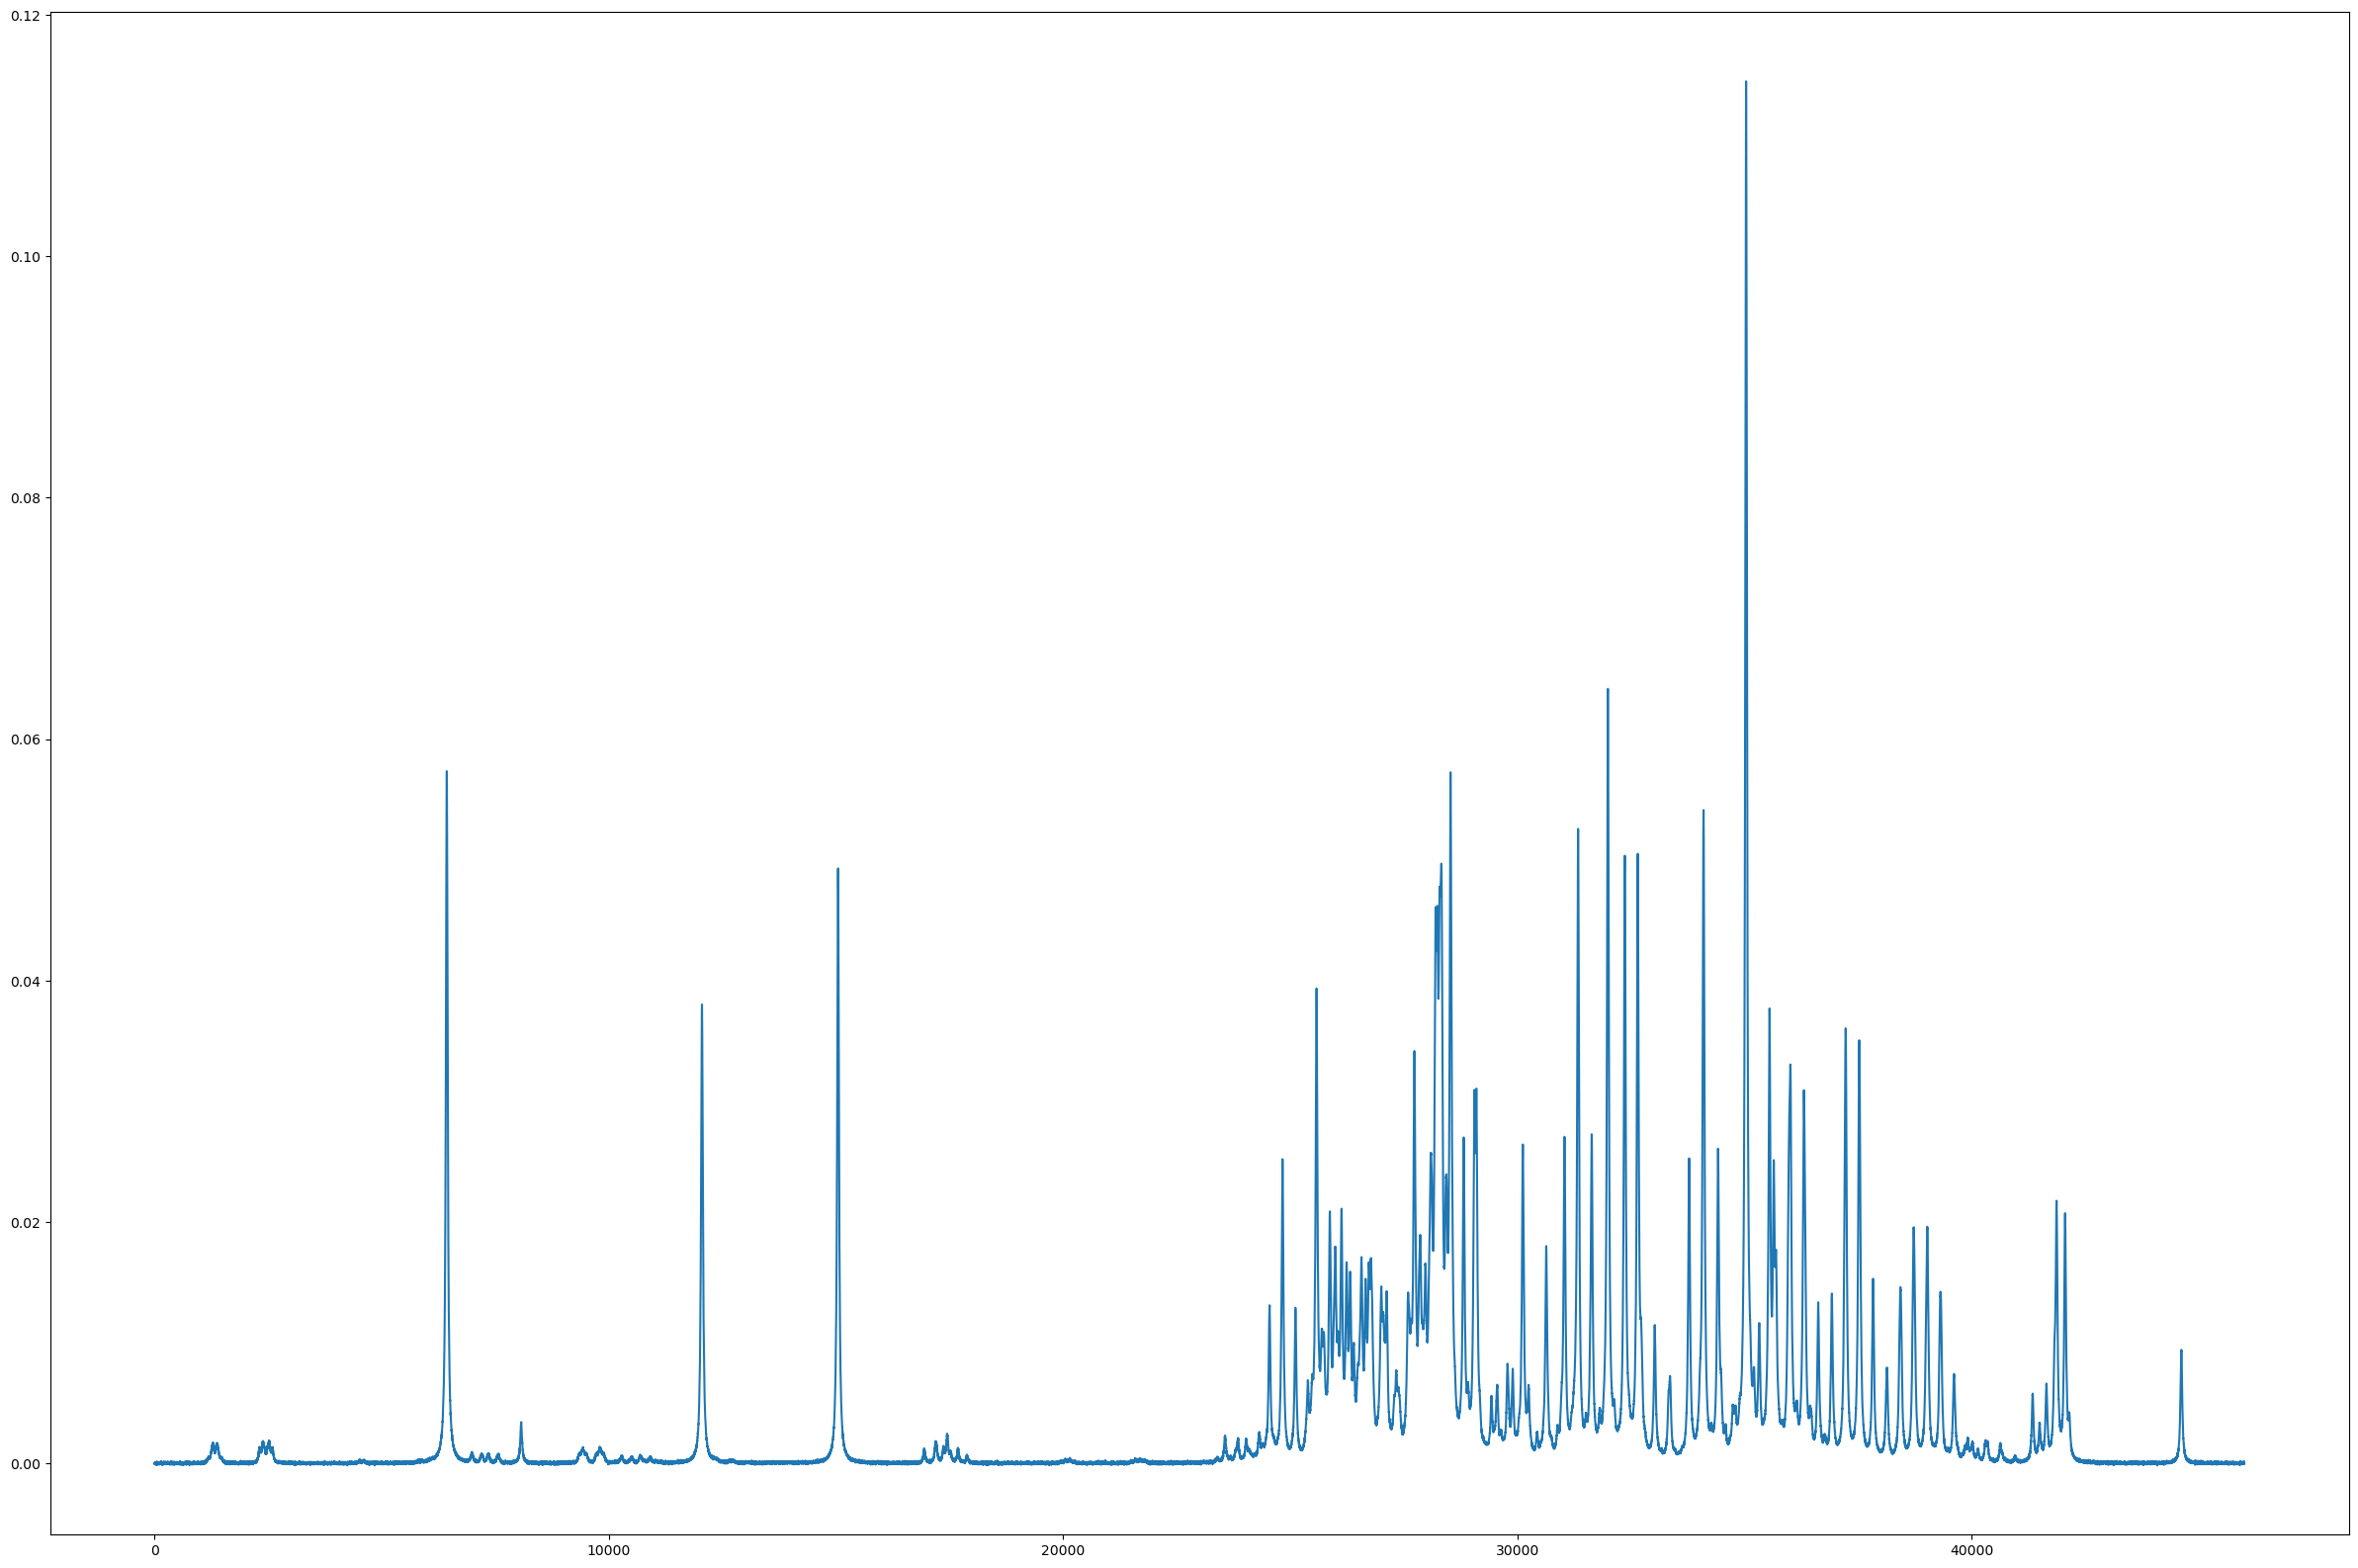

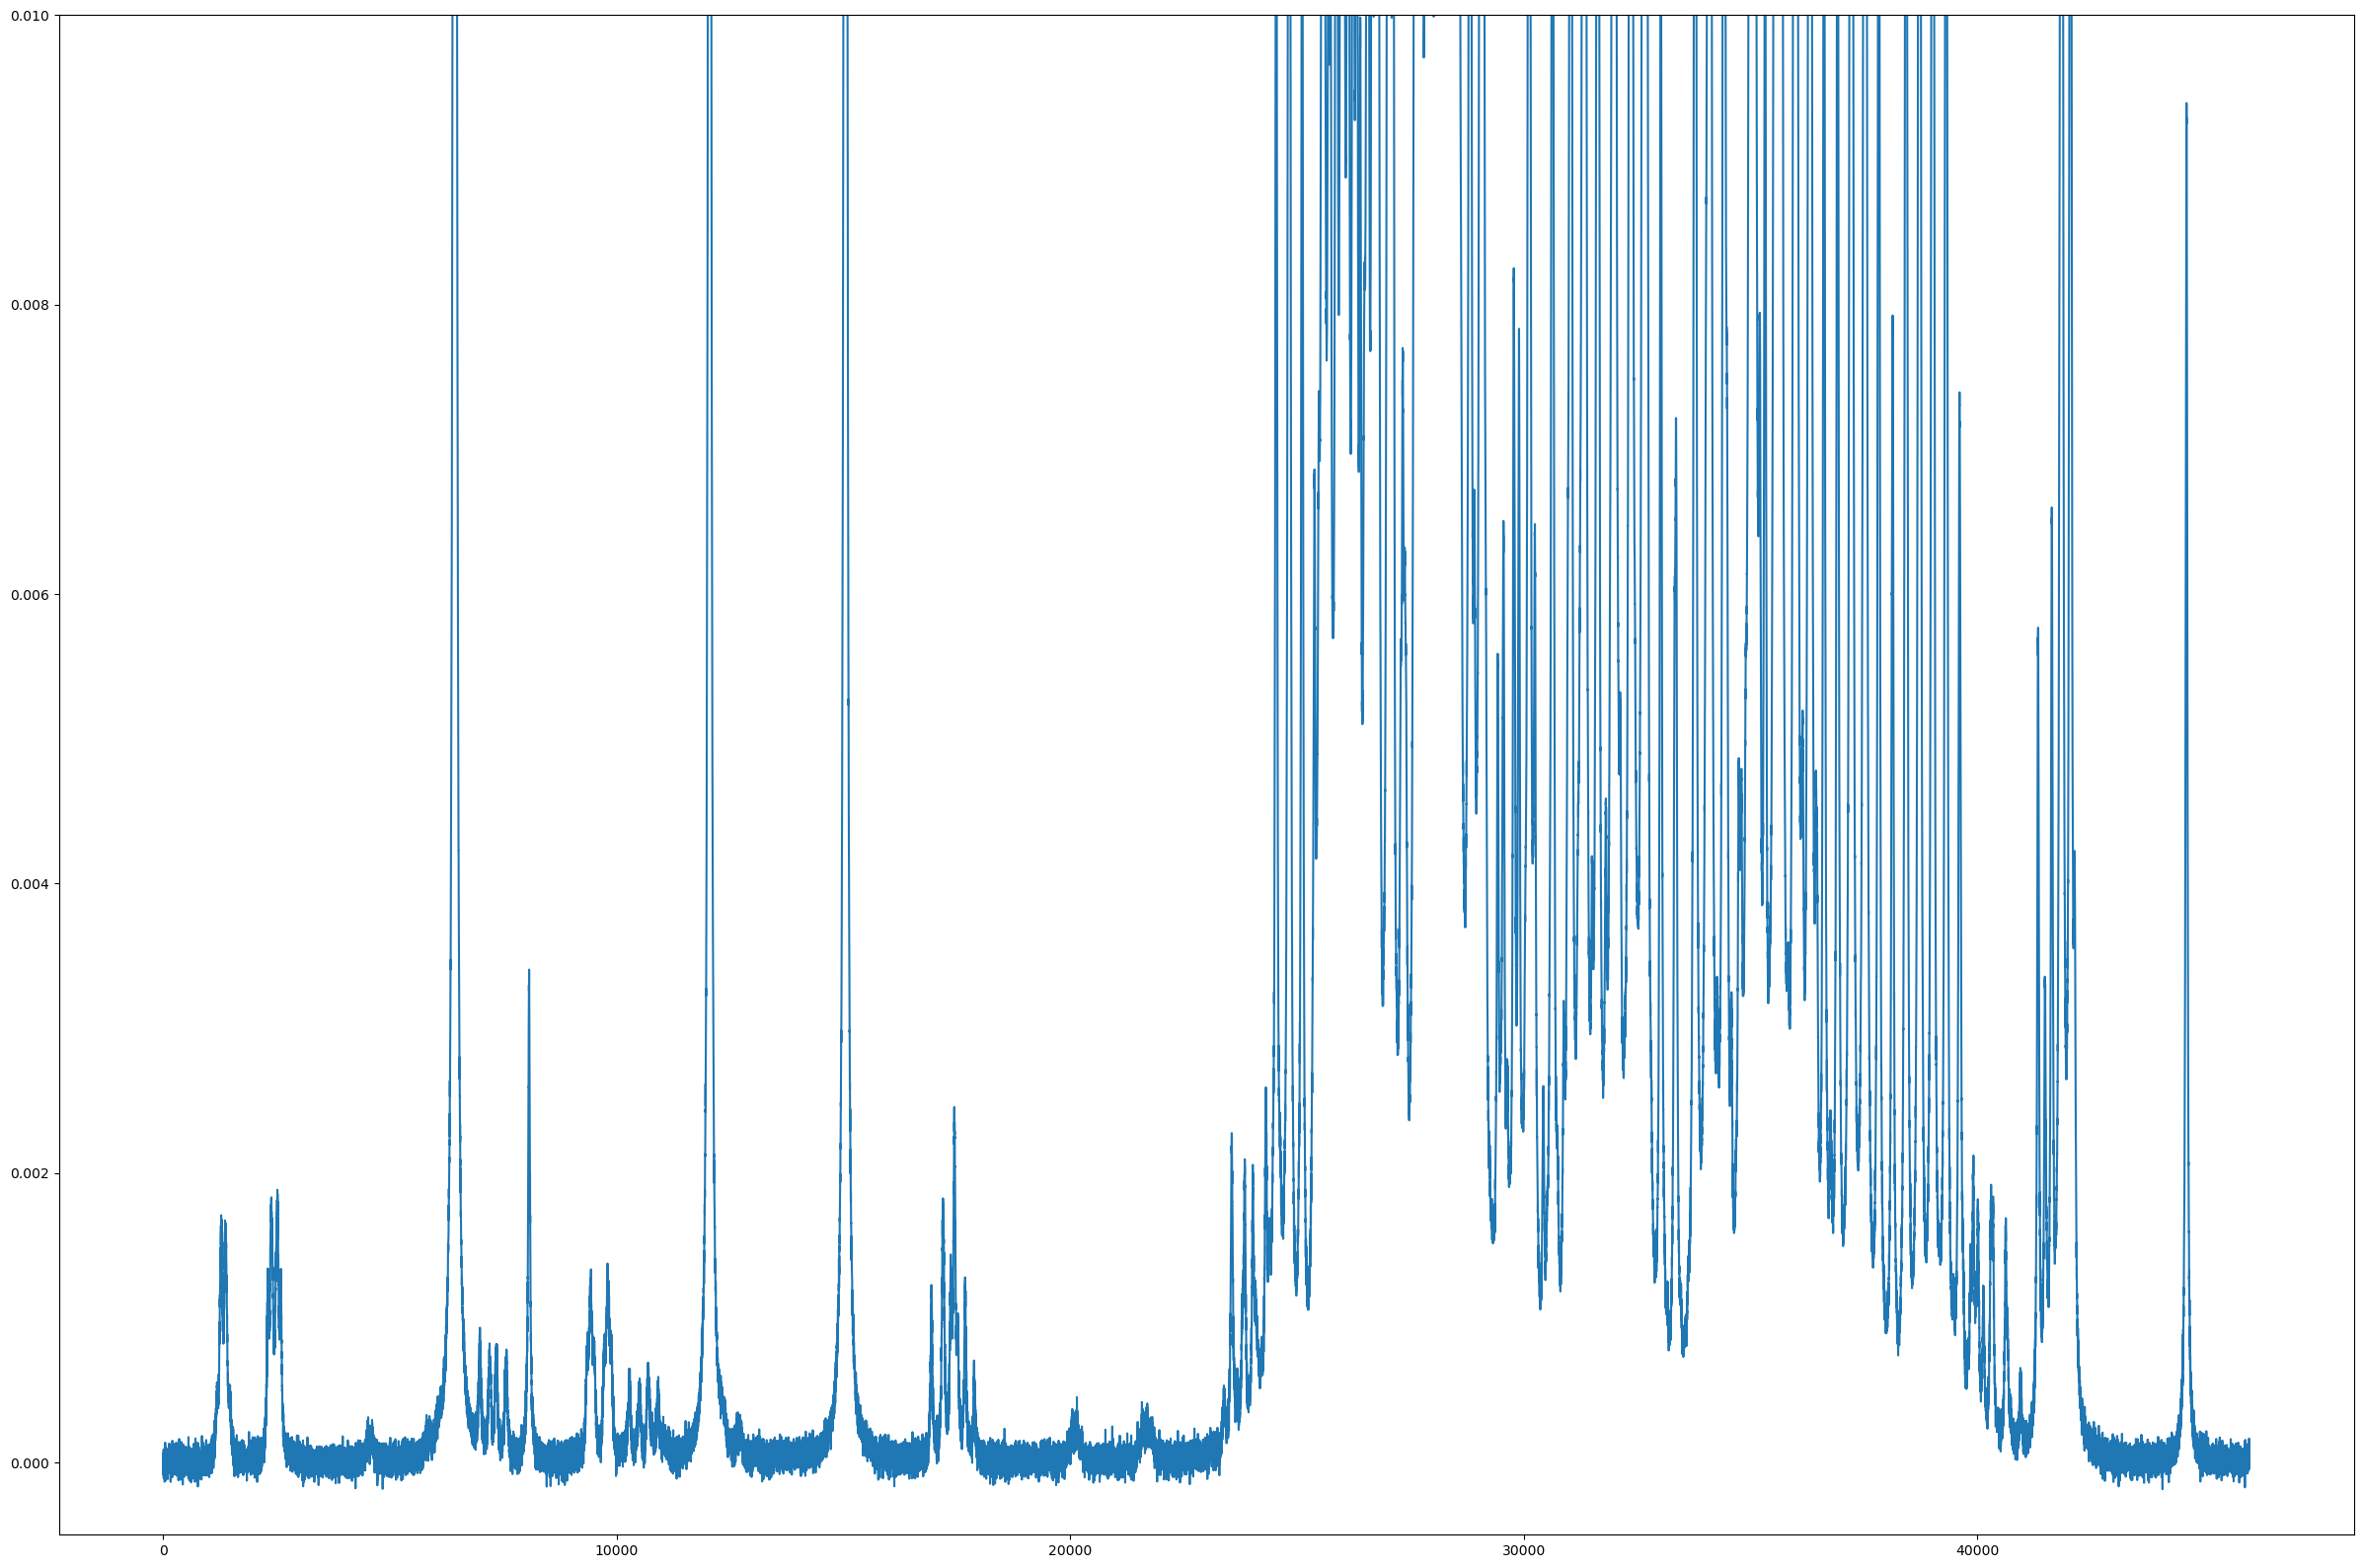

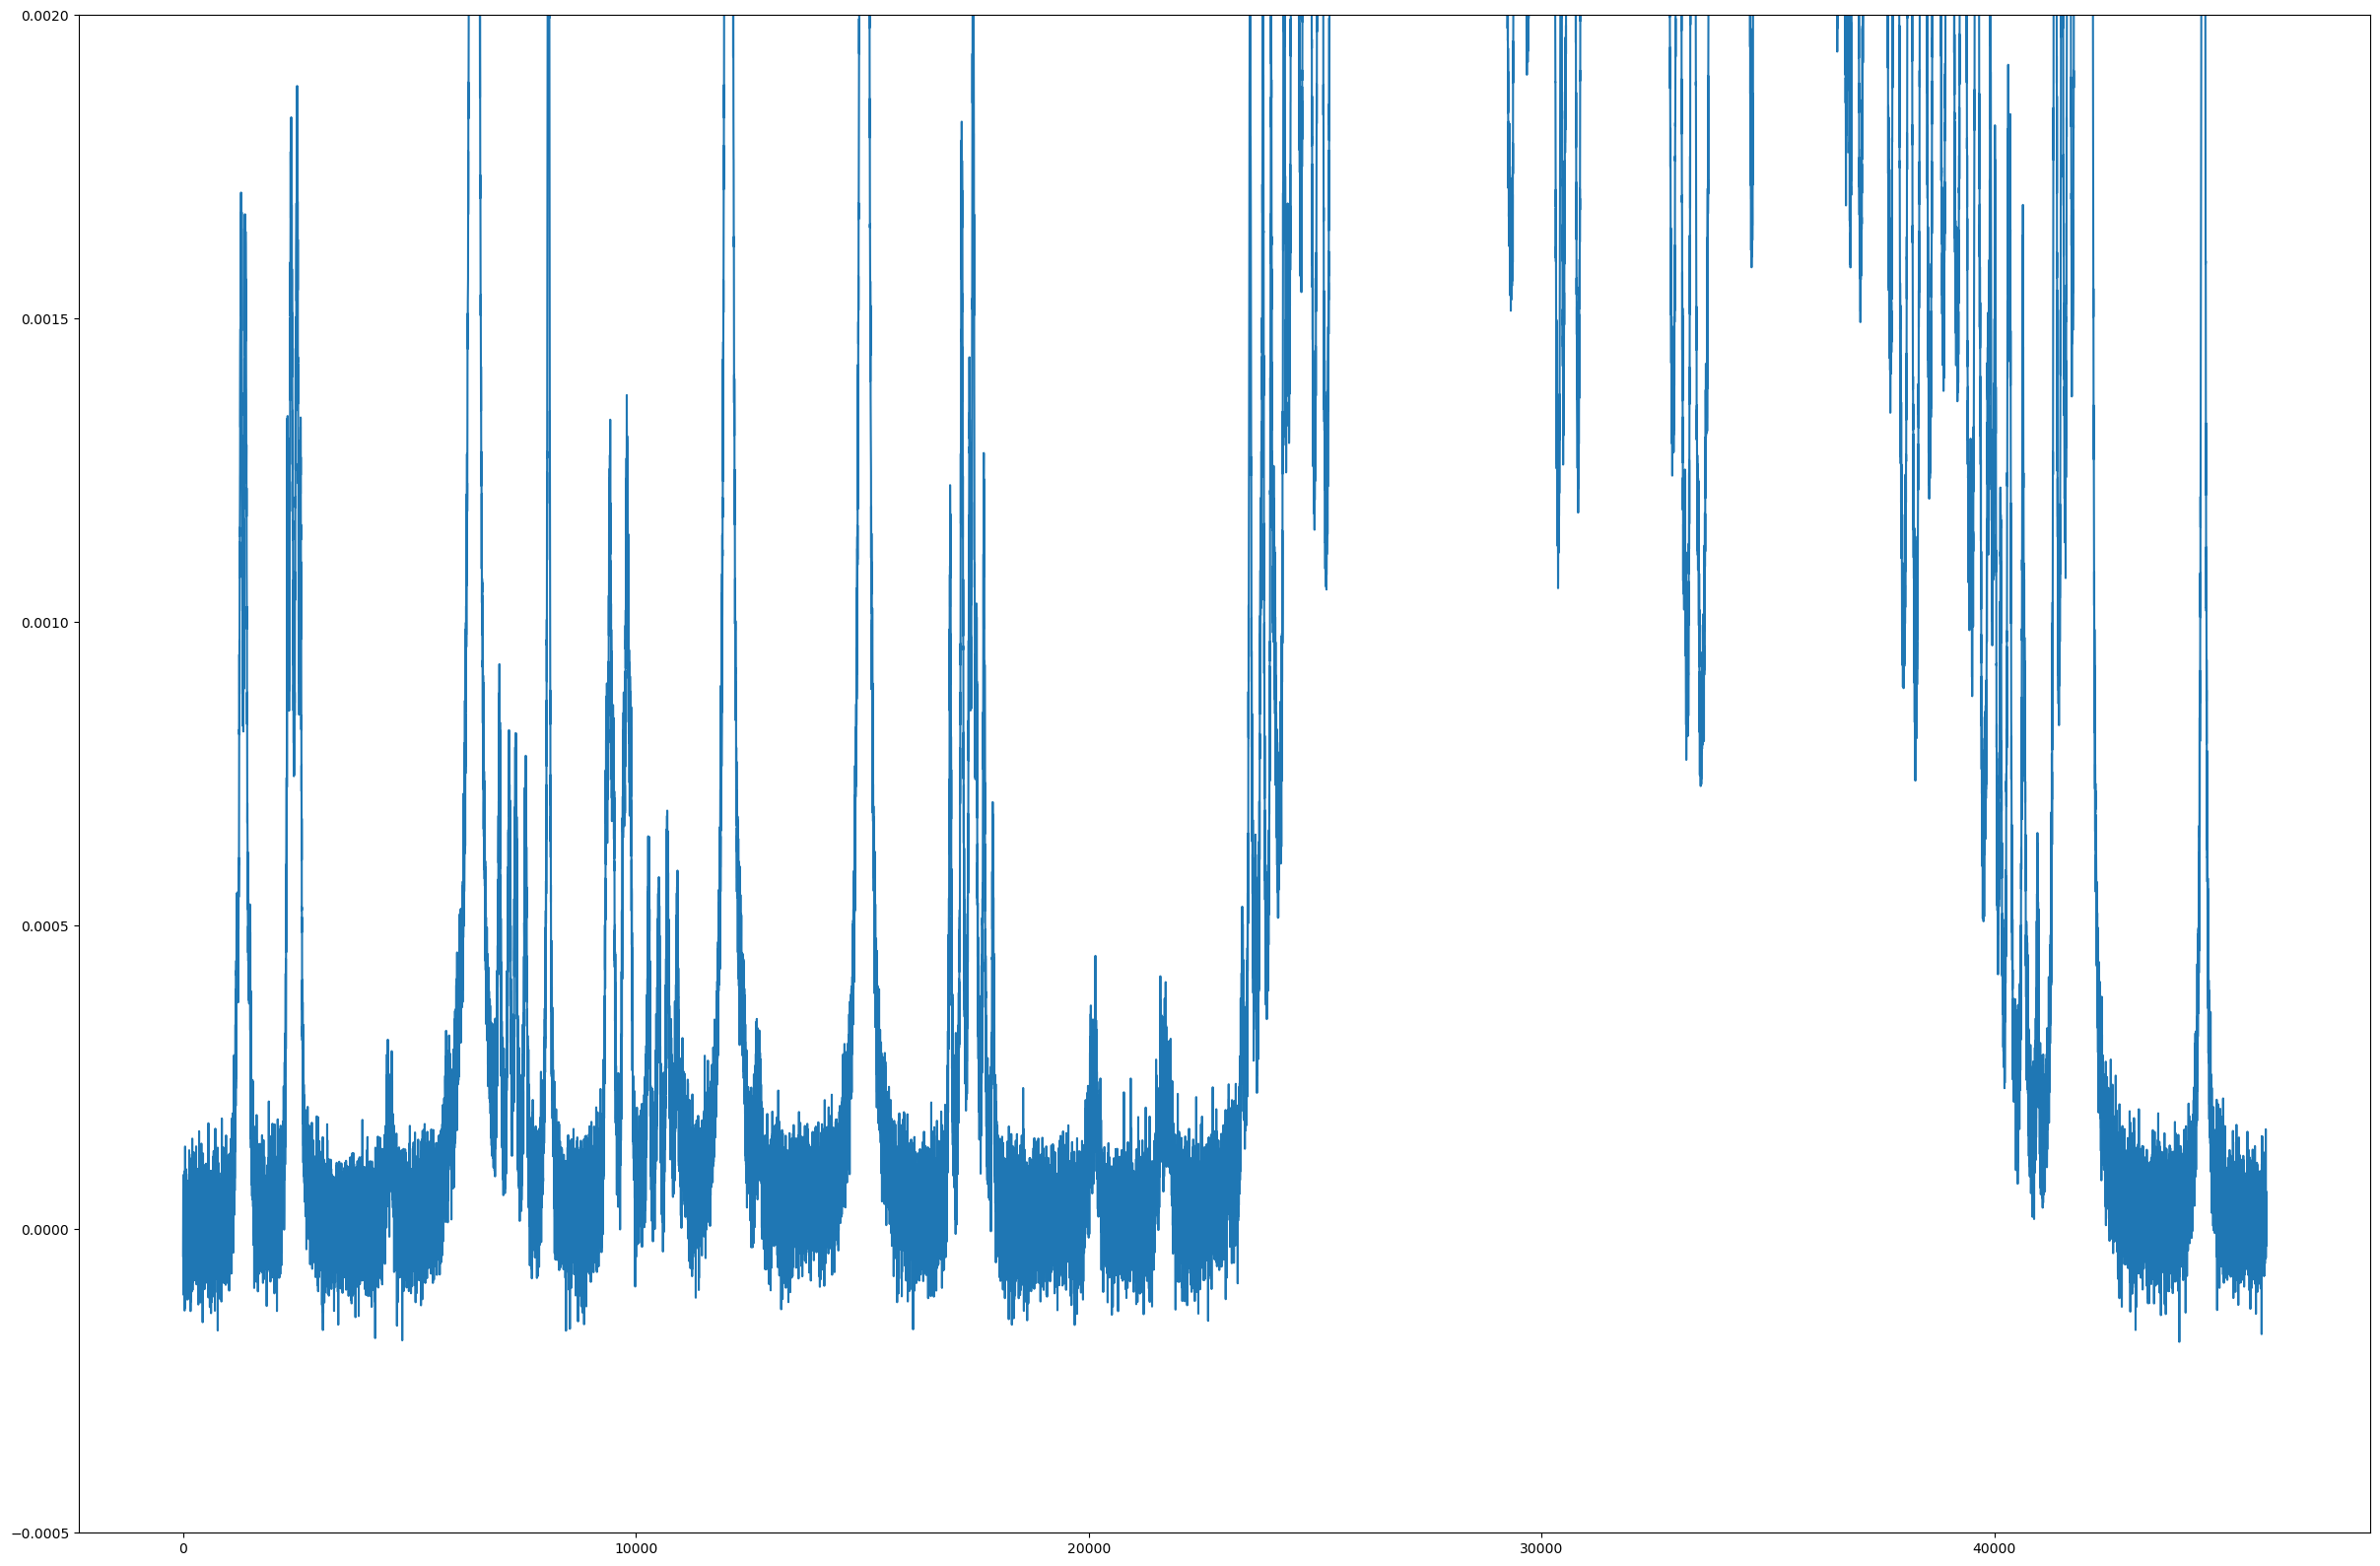

In [21]:
plt.plot(MimicTissueRangeSpec[0][0].detach().cpu().numpy())
plt.show()
plt.plot(MimicTissueRangeSpec[0][0].detach().cpu().numpy())
plt.ylim(-0.0005, 0.01)
plt.show()
plt.plot(MimicTissueRangeSpec[0][0].detach().cpu().numpy())
plt.ylim(-0.0005, 0.002)
plt.show()

In [22]:
## Compute absolute percent error statistics on tissue mimicking distribution validation spectra (high relative glucose concentration)

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = MimicTissueRangeGlucConc[i]
    model_aq.eval()
    Prediction = model_aq(MimicTissueRangeGlucSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "MimicTissueRangeGlucExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "MimicTissueRangeGlucExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(MimicTissueRangeGlucConc[i].min().item(),4), " - Mean Value:", np.round(MimicTissueRangeGlucConc[i].mean().item(),1))

Overall MAPE:  12.119194
--------------------
11.11  - Min Value: 0.0139  - Mean Value: 0.9
20.69  - Min Value: 0.0139  - Mean Value: 0.7
13.71  - Min Value: 0.0139  - Mean Value: 0.6
10.7  - Min Value: 0.0139  - Mean Value: 1.1
15.4  - Min Value: 0.0139  - Mean Value: 1.0
6.77  - Min Value: 0.0139  - Mean Value: 0.9
7.66  - Min Value: 0.0139  - Mean Value: 0.5
8.29  - Min Value: 0.0139  - Mean Value: 0.7
19.82  - Min Value: 0.0139  - Mean Value: 0.7
7.05  - Min Value: 0.0139  - Mean Value: 0.5


In [23]:
## Compute absolute percent error statistics on a further high dynamic range dataset

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = HighDynamicRange2Conc[i]
    model_aq.eval()
    Prediction = model_aq(HighDynamicRange2Spec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "HighDynamicRange2Examples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "HighDynamicRange2Examples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(HighDynamicRange2Conc[i].min().item(),4), " - Mean Value:", np.round(HighDynamicRange2Conc[i].mean().item(),1))

Overall MAPE:  65.22145
--------------------
104.35  - Min Value: 0.0066  - Mean Value: 5.8
66.08  - Min Value: 0.0067  - Mean Value: 6.9
23.48  - Min Value: 0.0082  - Mean Value: 6.1
61.14  - Min Value: 0.0076  - Mean Value: 6.6
51.98  - Min Value: 0.0074  - Mean Value: 5.7
52.43  - Min Value: 0.01  - Mean Value: 6.6
52.99  - Min Value: 0.0113  - Mean Value: 7.9
99.67  - Min Value: 0.0059  - Mean Value: 7.3
53.58  - Min Value: 0.0069  - Mean Value: 7.6
86.52  - Min Value: 0.0083  - Mean Value: 6.7


In [24]:
ConcConc[5]

tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
       device='cuda:0')

In [25]:
model_aq(ConcSpec[5])

tensor([[0.5011, 0.5059, 0.5047, 0.4922, 0.5035, 0.5079, 0.5149, 0.4958, 0.5167,
         0.4978, 0.4999, 0.4964, 0.5108, 0.4909, 0.4976, 0.5034, 0.5114, 0.4978,
         0.5025, 0.5023, 0.4987, 0.5050, 0.4944, 0.5045, 0.5010, 0.5032, 0.5057,
         0.5013, 0.5031, 0.5103, 0.5058, 0.5065, 0.4988, 0.4931, 0.5001, 0.4994,
         0.5041, 0.5150, 0.5149, 0.5049, 0.4996, 0.4895, 0.5043, 0.5065]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [26]:
ConcSpec.size()

torch.Size([10, 1, 46000])

In [27]:
SNR_Spec.size()

torch.Size([10, 1, 53500])

In [28]:
## Compute absolute percent error statistics on a examples of varying SNR

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = 0.43
    model_aq.eval()
    Prediction = model_aq(SNR_Spec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth - Prediction_cpu[0][metabolite]) / GroundTruth
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "SNR_Examples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "SNR_Examples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x54784 and 47104x44)

In [29]:
## Compute absolute percent error statistics on a dataset with singlets added at random

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = 0.43
    model_aq.eval()
    Prediction = model_aq(Singlet_Spec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth - Prediction_cpu[0][metabolite]) / GroundTruth
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "SingletExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "SingletExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2))

Overall MAPE:  5.915653246315098
--------------------
1.09
1.12
1.11
1.25
5.5
7.84
8.86
9.64
9.99
12.75


In [30]:
## Compute absolute percent error statistics on a examples of varying SNR

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = 0.43
    model_aq.eval()
    Prediction = model_aq(QrefSensSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth - Prediction_cpu[0][metabolite]) / GroundTruth
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "QrefSensitivity_Examples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "QrefSensitivity_Examples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2))

Overall MAPE:  92.9705809154026
--------------------
8.47
30.67
51.56
71.48
90.68
108.02
122.65
136.12
149.17
160.89


In [31]:
Pred = model_aq(OtherValSpectra[0])
Pred[0][Pred[0] < 0] = 0
print("Sinusoidal Baseline 1")
print(Pred[0])
print("___________")
print("___________")

Pred = model_aq(OtherValSpectra[1])
Pred[0][Pred[0] < 0] = 0
print("Sinusoidal Baseline 2")
print(Pred[0])
print("___________")
print("___________")

Pred = model_aq(OtherValSpectra[2])
Pred[0][Pred[0] < 0] = 0
print("HD-Range 1 - 0.01s and 20s")
print(Pred[0])

Pred = model_aq(OtherValSpectra[3])
Pred[0][Pred[0] < 0] = 0
print("HD-Range 2 - 0s and 20s")
print(Pred[0])

Sinusoidal Baseline 1
tensor([0.4479, 0.4759, 0.3356, 0.4361, 0.4779, 0.4684, 0.4556, 0.5180, 0.5264,
        0.4534, 0.4241, 0.4023, 0.4820, 0.6837, 0.4619, 0.5146, 0.5197, 0.4443,
        0.4538, 0.4217, 0.4249, 0.6805, 0.3685, 0.4802, 0.4913, 0.4360, 0.4575,
        0.5109, 0.5192, 0.4689, 0.4387, 0.4869, 0.4852, 0.4156, 0.4302, 0.4514,
        0.4363, 0.4388, 0.4936, 0.4074, 0.4230, 0.4454, 0.4712, 0.4461],
       device='cuda:0', grad_fn=<SelectBackward0>)
___________
___________
Sinusoidal Baseline 2
tensor([0.4245, 0.4755, 0.1743, 0.4754, 0.4439, 0.4636, 0.4121, 0.3632, 0.3363,
        0.5056, 0.4221, 0.4930, 0.4787, 0.2374, 0.4745, 0.3821, 0.6401, 0.4816,
        0.4371, 0.4054, 0.4194, 0.4911, 0.4331, 0.5170, 0.4139, 0.4540, 0.3932,
        0.2845, 0.5071, 0.4246, 0.4277, 0.4453, 0.3911, 0.4593, 0.4748, 0.4527,
        0.4882, 0.5122, 0.5184, 0.3658, 0.4377, 0.7130, 0.4181, 0.3875],
       device='cuda:0', grad_fn=<SelectBackward0>)
___________
___________
HD-Range 1 - 0.01s a